In [1]:
import sys
sys.executable

'C:\\Users\\jthqw\\myenv\\Scripts\\python.exe'

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from raytracing import *
from tdwg.lib.simulation import *
from tdwg.lib.DMD_patterns import *
import astropy.units as u
import astropy.constants as const

from scipy.ndimage import zoom
import sympy as sp


### Notes:
https://stackoverflow.com/questions/22442546/how-to-reload-after-from-module-import/22442644

## Simple tests of simulation model in Ref. 1 and answers to Question 1

In [3]:
from IPython.core.debugger import set_trace
from importlib import reload

def crazy_reload(package_string):
    exec(rf"import {package_string}")
    exec(rf"reload({package_string})")
    exec(rf"from {package_string} import *")

In [4]:
def gaussian_beam_from_q_parameter(wg, q, angle_deg=0, center_um=0*u.um):
    """
    All input except angle_deg must use astropy.units
    """
    k = wg.k0 * wg.n
    x = wg.x_axis
    dz = 0*u.um
    q0 = q
    #print(k,x,dz,q0)
    if angle_deg != 0:
        angle = angle_deg/180*np.pi
        dz = x * np.sin(-angle)
        x = x * np.cos(-angle)
        q = dz + q0
    return np.sqrt(q0/q) * np.exp(-1j*k * (dz + (x-center_um)**2/(2*q)))

DeprecationWarning [in quantity.py]: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
DeprecationWarning [in simulation.py]: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
DeprecationWarning [in simulation.py]: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
DeprecationWarning [in simulation.py]: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
DeprecationWarning [in simulation.py]: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)


Expected beam angle is 0.0 deg; simulated angle is 0.000 deg
tensor([1.0000+0.0000j, 1.0000-0.0004j, 1.0000-0.0015j,  ...,
        1.0000-0.0034j, 1.0000-0.0015j, 1.0000-0.0004j],
       dtype=torch.complex128)


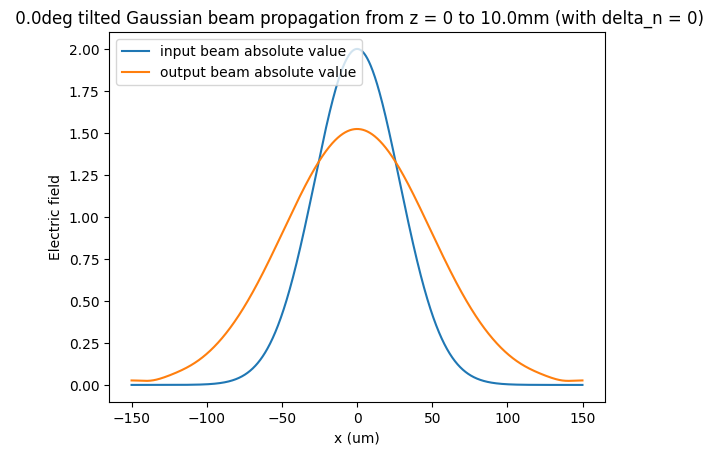

In [5]:
electrode_length = 10e3
scale_factor = 1
carrier_diffusion_length = 5

# chip parameters (lengths in MICROMETERS)
input_length = 0e3 # distance between input facet and electrode (um)
output_length = 0e3 # distance between output facet and electrode (um)
n_wg = 2.2 # effective index of waveguide
delta_n_val= 1.e-3 # (effective) index modulation in bright regions
pixel_size = electrode_length / (scale_factor*resY)

# simulation parameters
Lz = (input_length+electrode_length+output_length)*u.um # length of waveguide in microns
Lx = 300*u.um # width of simulated waveguide area in microns 
Nx = 2**11 
dz = 1.55*u.um / delta_n_val / 100
Nz = int(Lz / dz)

# create waveguide simulation object
wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50)

# buttcoupling parameters
angle_deg = 0.0 #angle between waveguide facet normal and input beam in degree
w0 = 40 # beam waist (um)
#w0 = 100 # beam waist (um)

rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
E = np.abs(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
input_beam = torch.from_numpy(2*gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg))

delta_n = torch.from_numpy(np.zeros((Nz, Nx), dtype=np.float32))
delta_n = delta_n.to(dtype=torch.float32)  # Ensure it's float32
delta_n = delta_n * (1+0*1j)
wg.set_delta_n(delta_n)

data_V_on = wg.run_simulation(input_beam)
plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "input beam absolute value")
plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "output beam absolute value")
delta_x_sim = wg.x_axis[np.argmax(np.abs(data_V_on.numpy()))]
angle_deg_sim = delta_x_sim/electrode_length/u.um/np.pi*180

plt.xlabel('x (um)')
plt.ylabel('Electric field')
plt.title(f' {angle_deg}deg tilted Gaussian beam propagation from z = 0 to {electrode_length/1000}mm (with delta_n = 0)')
plt.legend()
print(f"Expected beam angle is {angle_deg} deg; simulated angle is {angle_deg_sim:.3f} deg")
print(wg.difr_list)
#plt.pcolormesh(wg.z_axis/1e3, wg.x_axis, torch.abs((data_V_on).cpu()).T, cmap="inferno")

In [6]:
#wg.plot_mats()

150.0 um 14.16 30.72 3.584
0 1024


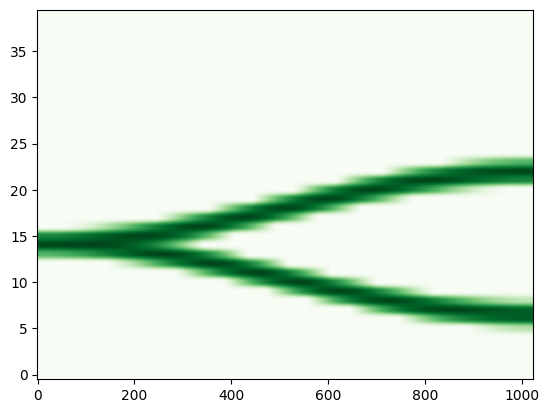

In [7]:
def generate_grin_guide_slice(cut_ind, width_one_side):
    slice_left = create_grin_beamsteerer_slice(cut_ind-width_one_side, width_one_side, slope_positive=True)
    slice_right = create_grin_beamsteerer_slice(cut_ind+width_one_side, width_one_side, slope_positive=False)
    return slice_left + slice_right - 255

#Create y-beamsplitter
xcenter = 0*u.um
xsep = 150*u.um
xwidth = 35*u.um
zstart = 0*u.um
zend = electrode_length*u.um

DMD_xcenter = (xcenter+Lx/2) * resY/Lz-1.2

DMD_xsep = xsep * resY/Lz
DMD_xwidth = xwidth * resY/Lz
DMD_ystart = zstart * resY/Lz
DMD_yend = zend * resY/Lz


print(xcenter+Lx/2,DMD_xcenter,Lx*resY/Lz,DMD_xwidth)

def sbend(idx):
    del_y = (DMD_yend - DMD_ystart)/2
    del_x = DMD_xsep/2
    return del_x/2 - del_x/2 * np.cos((idx-DMD_ystart)*np.pi/(2*del_y)*u.rad)

start = np.max([int(np.floor(DMD_ystart)), 0])
end = np.min([int(np.ceil(DMD_yend)),resY])
print(start,end)

img = generate_all_off()
for idx in np.arange(start, end):
    slice1 = generate_grin_guide_slice((DMD_xcenter + sbend(idx)).to_value(), DMD_xwidth.to_value()/4)
    slice2 = generate_grin_guide_slice((DMD_xcenter - sbend(idx)).to_value(), DMD_xwidth.to_value()/4)
    img[:, idx] = 255 - 255* (255-np.maximum(slice1, slice2).astype(float))**2/255**2
img = img.astype(np.uint8)


#img = generate_grin_y_splitter(np.arange(100,201), 100, 20)
#plot_DMD_img(img)
plt.imshow(img[0:40,:], aspect="auto", origin="lower", cmap="Greens", vmin=0)

(30, 1024) (2097, 645) (69.9, 0.6298828125)


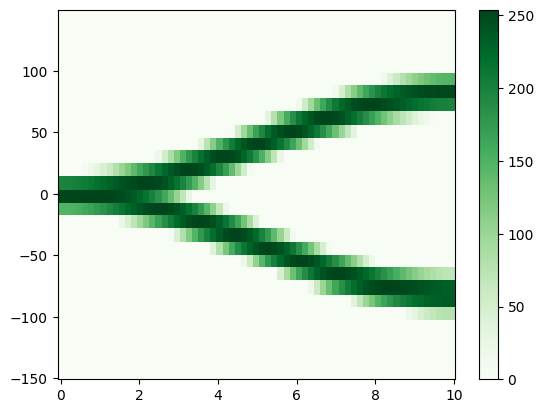

In [8]:

# Define source 2D array
resY_eff = Lx*resY/Lz
source = img[0:int(resY_eff),:].astype(np.float32)

# Define target dimensions
target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)

# Compute zoom factors
zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
print(source.shape,target_shape, zoom_factors)

# Rescale array
target = zoom(source, zoom_factors, order=0)  # order=1 for bilinear interpolation
target = target[0:Nx,:]
plt.pcolormesh(wg.z_axis[::10].to_value()/1e3, wg.x_axis[::10].to_value(),target[::10, ::10], cmap="Greens", vmin=0)
plt.colorbar()


DeprecationWarning [in simulation.py]: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)


(<Figure size 1000x600 with 12 Axes>,
 array([[<Axes: title={'center': 'Original $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Original $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Steady-state $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Steady-state $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Spatial intensity'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Wavevector intensity'}, xlabel='z (mm)', ylabel='f (1/mm)'>]],
       dtype=object))

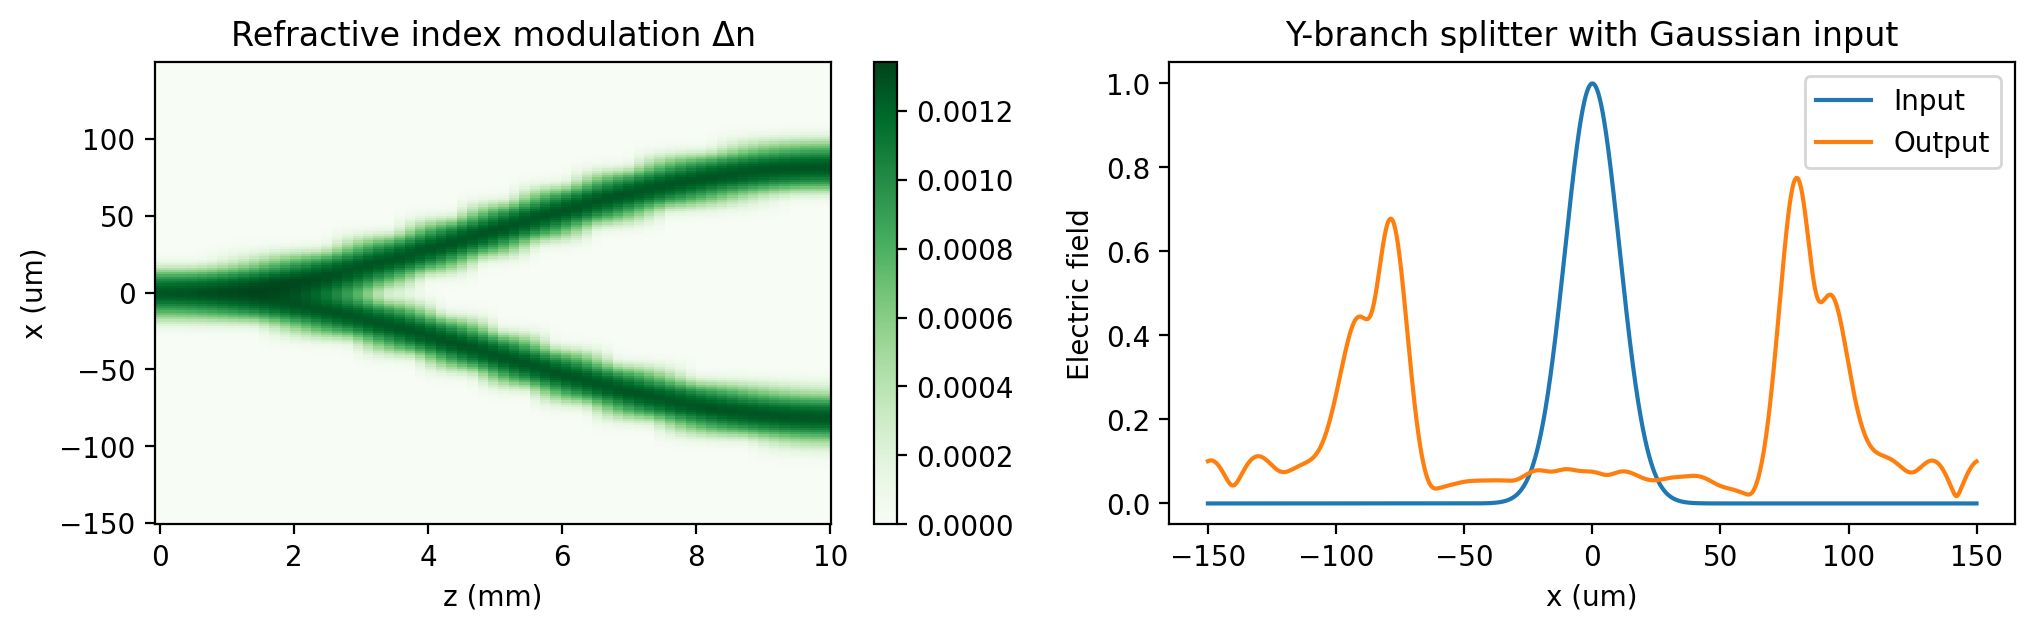

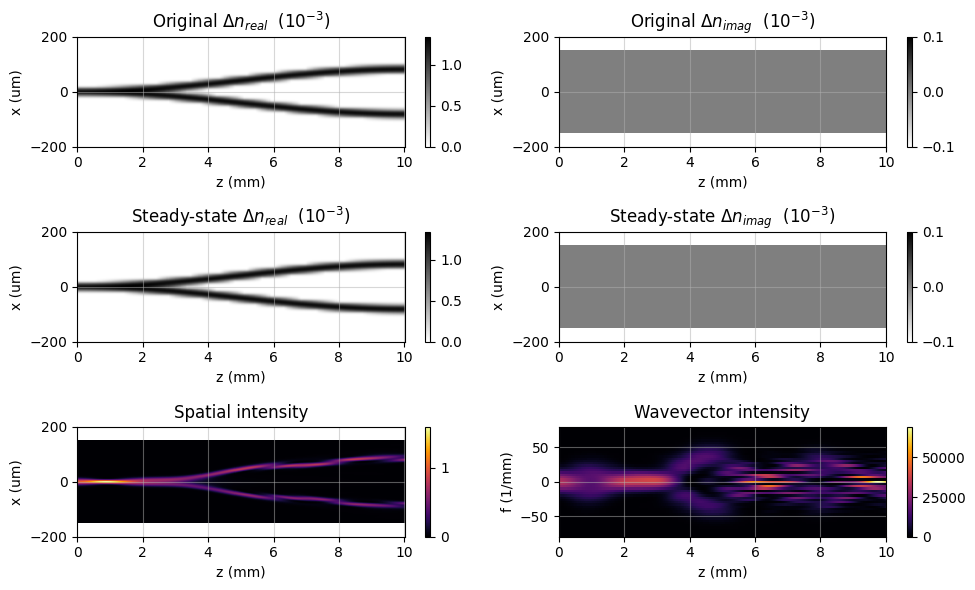

In [9]:


# create waveguide simulation object

wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um)

# buttcoupling parameters
angle_deg = 0.0 #angle between waveguide facet normal and input beam in degree
w0 = 15 # beam waist (um)
rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
E = np.abs(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
input_beam = torch.from_numpy(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg))

delta_n = torch.from_numpy(target.T/255*0.0014)
delta_n = delta_n.to(dtype=torch.float32)  # Ensure it's float32
#wg.smoothen_spatial_map(delta_n)
delta_n_diffused = wg.smoothen_spatial_map(delta_n)
wg.set_delta_n(delta_n_diffused)
data_V_on = wg.run_simulation_slow(input_beam)

fig, axs = plt.subplots(1, 2, figsize = [12,3], dpi = 200)

plt.sca(axs[0])
plt.pcolormesh(wg.z_axis[::10].to_value()/1e3, wg.x_axis[::10].to_value(),delta_n_diffused.T[::10, ::10], cmap="Greens", vmin=0)
plt.colorbar()
plt.xlabel('z (mm)')
plt.ylabel('x (um)')
plt.title('Refractive index modulation Δn')

plt.sca(axs[1])
plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "Input")
plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "Output")
delta_x_sim = wg.x_axis[np.argmax(np.abs(data_V_on.numpy()))]
angle_deg_sim = delta_x_sim/electrode_length/u.um/np.pi*180
plt.xlabel('x (um)')
plt.ylabel('Electric field')
plt.title(f'Y-branch splitter with Gaussian input')
plt.legend()
wg.plot_mats(renorm_flag = False)
#plt.pcolormesh(wg.z_axis/1e3, wg.x_axis, torch.abs((data_V_on).cpu()).T, cmap="inferno")

In [10]:
electrode_length = 10e3
scale_factor = 1
carrier_diffusion_length = 5

# chip parameters (lengths in MICROMETERS)
input_length = 0e3 # distance between input facet and electrode (um)
output_length = 0e3 # distance between output facet and electrode (um)
n_wg = 2.2 # effective index of waveguide
delta_n_val= 1.e-3 # (effective) index modulation in bright regions
pixel_size = electrode_length / (scale_factor*resY)

# simulation parameters
Lz = (input_length+electrode_length+output_length)*u.um # length of waveguide in microns
Lx = 300*u.um # width of simulated waveguide area in microns 
Nx = 2**11 
dz = 1.55*u.um / delta_n_val / 100
Nz = int(Lz / dz)

# create waveguide simulation object
wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um)

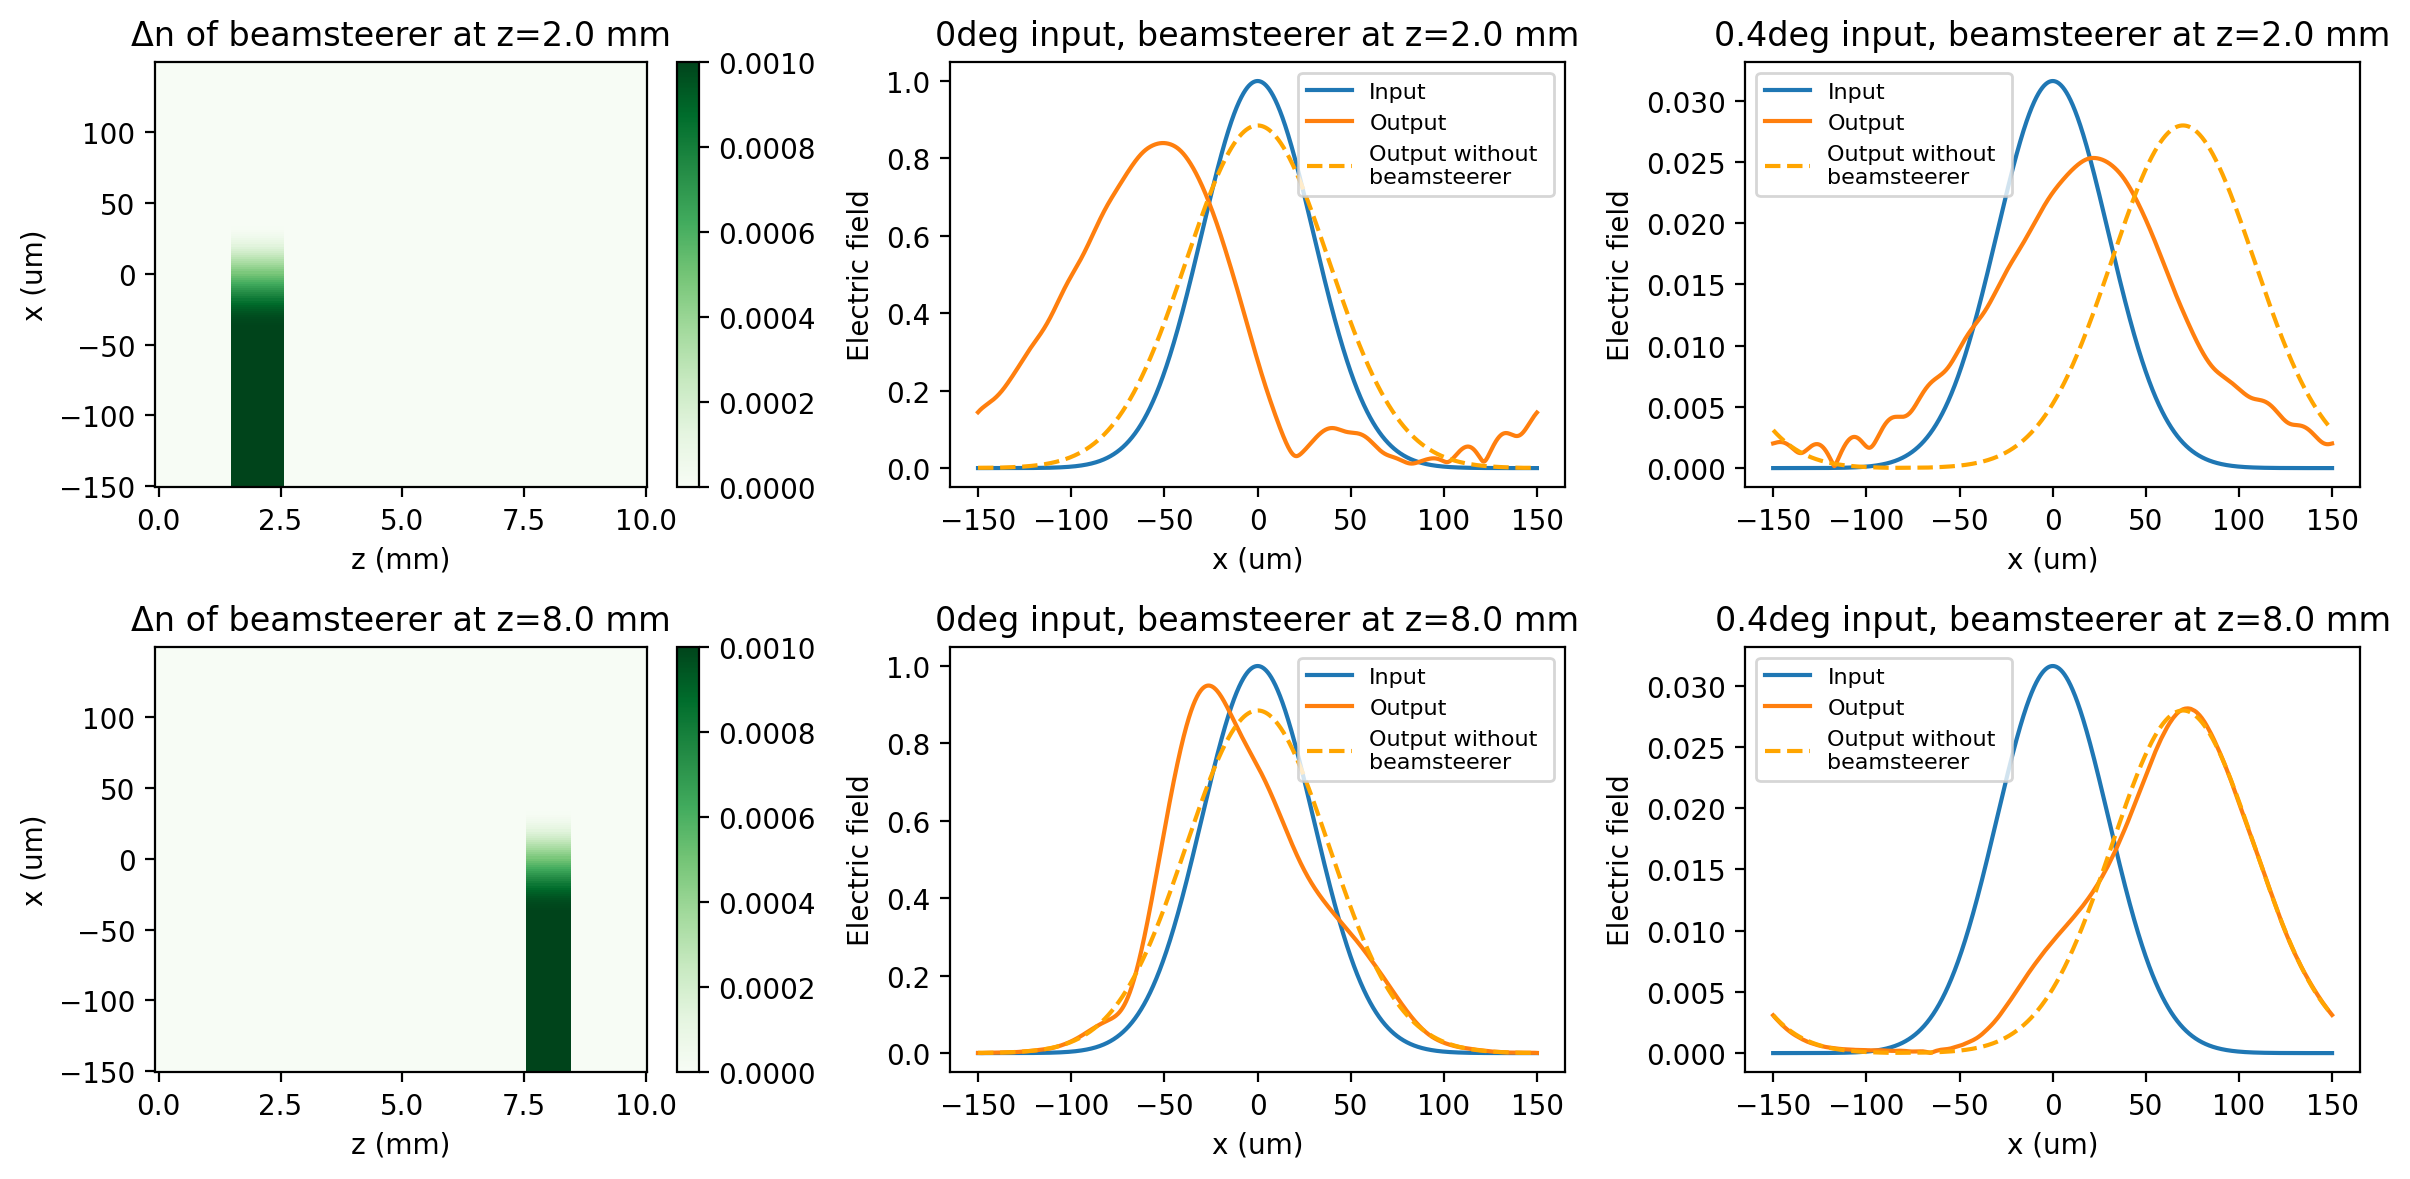

In [11]:
delta_n_off = torch.from_numpy(np.zeros((Nz, Nx), dtype=np.float32))

xwidth = 50*u.um
zwidth = 1e3*u.um
fig, axs = plt.subplots(2, 3, figsize = [12,6], dpi = 200)
i=0
#
for zposition in [2*u.mm, 8*u.mm]:
    DMD_xcenter = Lx/2 * resY/Lz-1.2
    DMD_xwidth = xwidth * resY/Lz
    DMD_zposition = zposition * resY/Lz
    DMD_zwidth = zwidth * resY/Lz
    z_range = np.arange(int(DMD_zposition-DMD_zwidth/2),int(DMD_zposition+DMD_zwidth/2))
    img = generate_grin_beamsteerer(z_range, DMD_xcenter, DMD_xwidth/2, slope_positive=False)
    
    resY_eff = Lx*resY/Lz
    source = img[0:int(resY_eff),:].astype(np.float32)
    target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)
    zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
    target = zoom(source, zoom_factors, order=0)
    target = target[0:Nx,:]
    
    delta_n = torch.from_numpy(target.T/255*0.001)
    delta_n = delta_n.to(dtype=torch.float32)  # Ensure it's float32
    delta_n_diffused = wg.smoothen_spatial_map(delta_n)
    wg.set_delta_n(delta_n_diffused)
    plt.sca(axs.flatten()[i])
    plt.pcolormesh(wg.z_axis[::10].to_value()/1e3, wg.x_axis[::10].to_value(),delta_n_diffused.T[::10, ::10], cmap="Greens", vmin=0)
    plt.colorbar()
    plt.xlabel('z (mm)')
    plt.ylabel('x (um)')
    plt.title(f'Δn of beamsteerer at z={zposition}')
    i += 1
    for angle_deg in [0, 0.4]:  #angle between waveguide facet normal and input beam in degree
        # buttcoupling parameters
        w0 = 30 # beam waist (um)
        rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
        E = np.abs(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
        z0 = 4*u.mm
        input_beam = torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, angle_deg))
        
        data_V_on = wg.run_simulation(input_beam, delta_n = delta_n_diffused).clone()
        data_V_off = wg.run_simulation(input_beam,delta_n = delta_n_off).clone()
        
        plt.sca(axs.flatten()[i])
        plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "Input")
        plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "Output")
        
        plt.plot(wg.x_axis.to_value(),np.abs(data_V_off.numpy()), "--", color = "orange", label = f"Output without \nbeamsteerer")
        delta_x_sim = wg.x_axis[np.argmax(np.abs(data_V_on.numpy()))]
        angle_deg_sim = delta_x_sim/electrode_length/u.um/np.pi*180
        plt.xlabel('x (um)')
        plt.ylabel('Electric field')
        plt.title(f"{angle_deg}deg input, beamsteerer at z={zposition}")
        plt.legend(fontsize=8)
        plt.tight_layout()
        i += 1

Half width of delta_n pattern is 76.77923342053572 um


(<Figure size 1000x600 with 12 Axes>,
 array([[<Axes: title={'center': 'Original $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Original $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Steady-state $\\Delta n_{real}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Steady-state $\\Delta n_{imag}\\ \\  (10^{-3})$'}, xlabel='z (mm)', ylabel='x (um)'>],
        [<Axes: title={'center': 'Spatial intensity'}, xlabel='z (mm)', ylabel='x (um)'>,
         <Axes: title={'center': 'Wavevector intensity'}, xlabel='z (mm)', ylabel='f (1/mm)'>]],
       dtype=object))

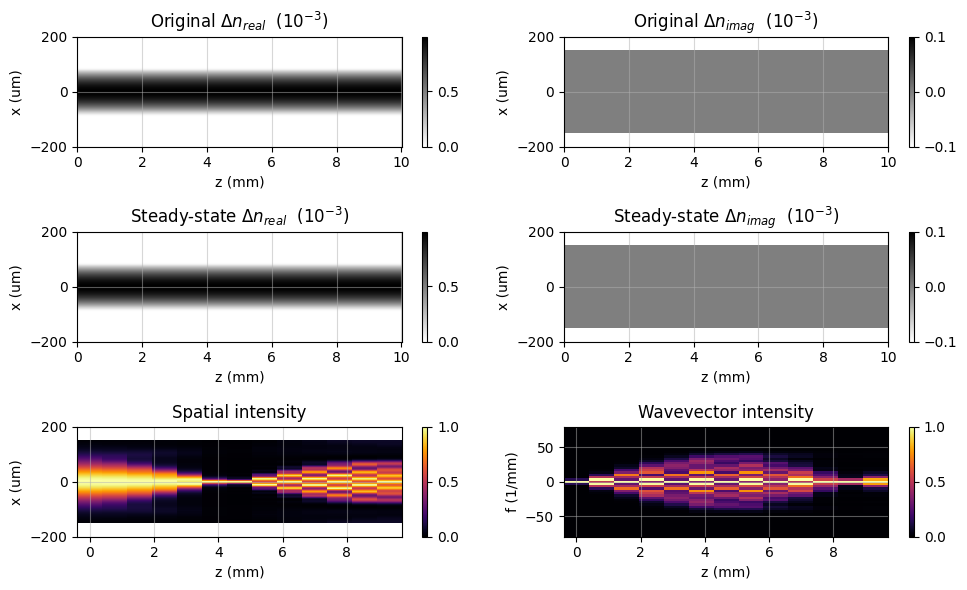

In [12]:
f = 4*u.mm  # focal length of lens
delta_n_max = 1e-3

"""
From the Eikonal ray equation, we know a quadratic delta_n(x) is needed to form a lens.
I use: delta_n(x) = delta_n_max * (1 - (x/xwidth)**2)
Using the ray equation, the xwidth needed to make a lens with focal length f is below.
(The same result can be obtained from Gaussian beam and ABCD matrix)
"""
xwidth = f.to(u.um) * sqrt(2*delta_n_max/n_wg) * 2/np.pi  # width of pattern needed for focal length f
print(f"Half width of delta_n pattern is {xwidth}")
DMD_xcenter = Lx/2 * resY/Lz-1.2
DMD_xwidth = xwidth * resY/Lz
DMD_zposition = zposition * resY/Lz
DMD_zwidth = zwidth * resY/Lz
z_range = np.arange(0, resY)
img = generate_grin_y_splitter(z_range, DMD_xcenter, DMD_xwidth/2)
img = 255 - 255 * (255-img.astype(float))**2/255**2
img = img.astype(np.uint8)

resY_eff = Lx*resY/Lz
source = img[0:int(resY_eff),:].astype(np.float32)
target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)
zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
target = zoom(source, zoom_factors, order=0)
target = target[0:Nx,:]

delta_n = torch.from_numpy(target.T/255*0.001)
delta_n = delta_n.to(dtype=torch.float32)  # Ensure it's float32
delta_n_diffused = wg.smoothen_spatial_map(delta_n)

wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50)
w0 = 100 # beam waist (um)
rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
#E = np.abs(gaussian_beam_from_q_parameter(wg, 1j*rayleigh_range, angle_deg, center_um = 0))
z0 = 0*u.mm
input_beam = torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0))

data_V_on = wg.run_simulation_slow(input_beam, delta_n = delta_n_diffused).clone()
wg.plot_mats()

## Testing simple model of saturable gain

UserWarning [in fft_conv.py]: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:308.)


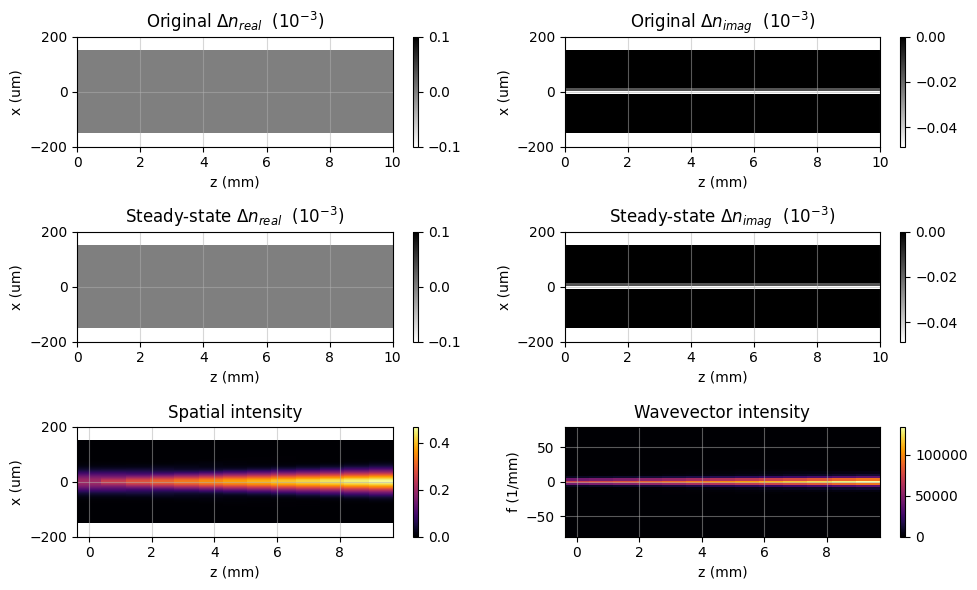

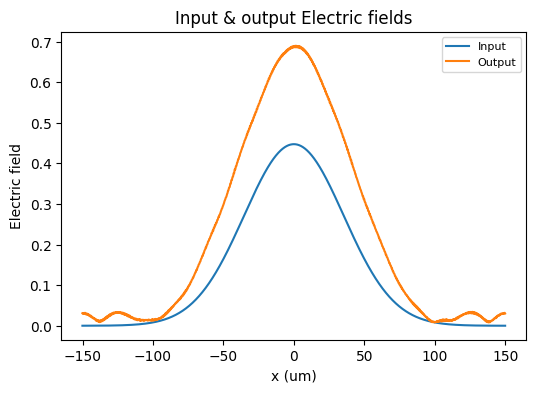

In [13]:
I_sat = 1 # Saturation intensity, defined as E^2 for simplicity
I_in = 0.2 # Input light max intensity

delta_n_max = 1e-3
n_i_min = -5e-5 # minimum n_imag of modulation pattern
xwidth = u.um * 10 # half-width-at-zero of delta_n pattern

w0 = 50 # beam waist (um)

DMD_xcenter = Lx/2 * resY/Lz-1.2
DMD_xwidth = xwidth * resY/Lz
DMD_zposition = zposition * resY/Lz
DMD_zwidth = zwidth * resY/Lz
z_range = np.arange(0, resY)
img = generate_grin_y_splitter(z_range, DMD_xcenter, DMD_xwidth/2)
img = 255 - 255 * (255-img.astype(float))**2/255**2
img = img.astype(np.uint8)

resY_eff = Lx*resY/Lz
source = img[0:int(resY_eff),:].astype(np.float32)
target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)
zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
target = zoom(source, zoom_factors, order=0)
target = target[0:Nx,:]

delta_n = torch.from_numpy(target.T/255*n_i_min*1j)
delta_n = delta_n.to(dtype=torch.complex64)  
delta_n_diffused = wg.smoothen_spatial_map(delta_n)

wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50, I_sat = I_sat)


rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
z0 = 0*u.mm
input_beam = np.sqrt(I_in) * torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0,center_um=0*u.um))

data_V_on = wg.run_simulation_slow(input_beam, delta_n = delta_n).clone()
wg.plot_mats(renorm_flag=False)

fig, axs2 = plt.subplots(1, 1, figsize=(6, 4))  # Create a new axis for the plot below
plt.sca(axs2)
plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "Input")
plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "Output")
plt.xlabel('x (um)')
plt.ylabel('Electric field')
plt.title("Input & output Electric fields")
plt.legend(fontsize=8)

## Define Material class

(A copy of the code when it was under development is below. The working code is in simulation.py.)

## Plotting simulated steady-state refractive index vs current and optical power


material properties


Text(0.5, 1.0, '$n_{eff,imag}$')

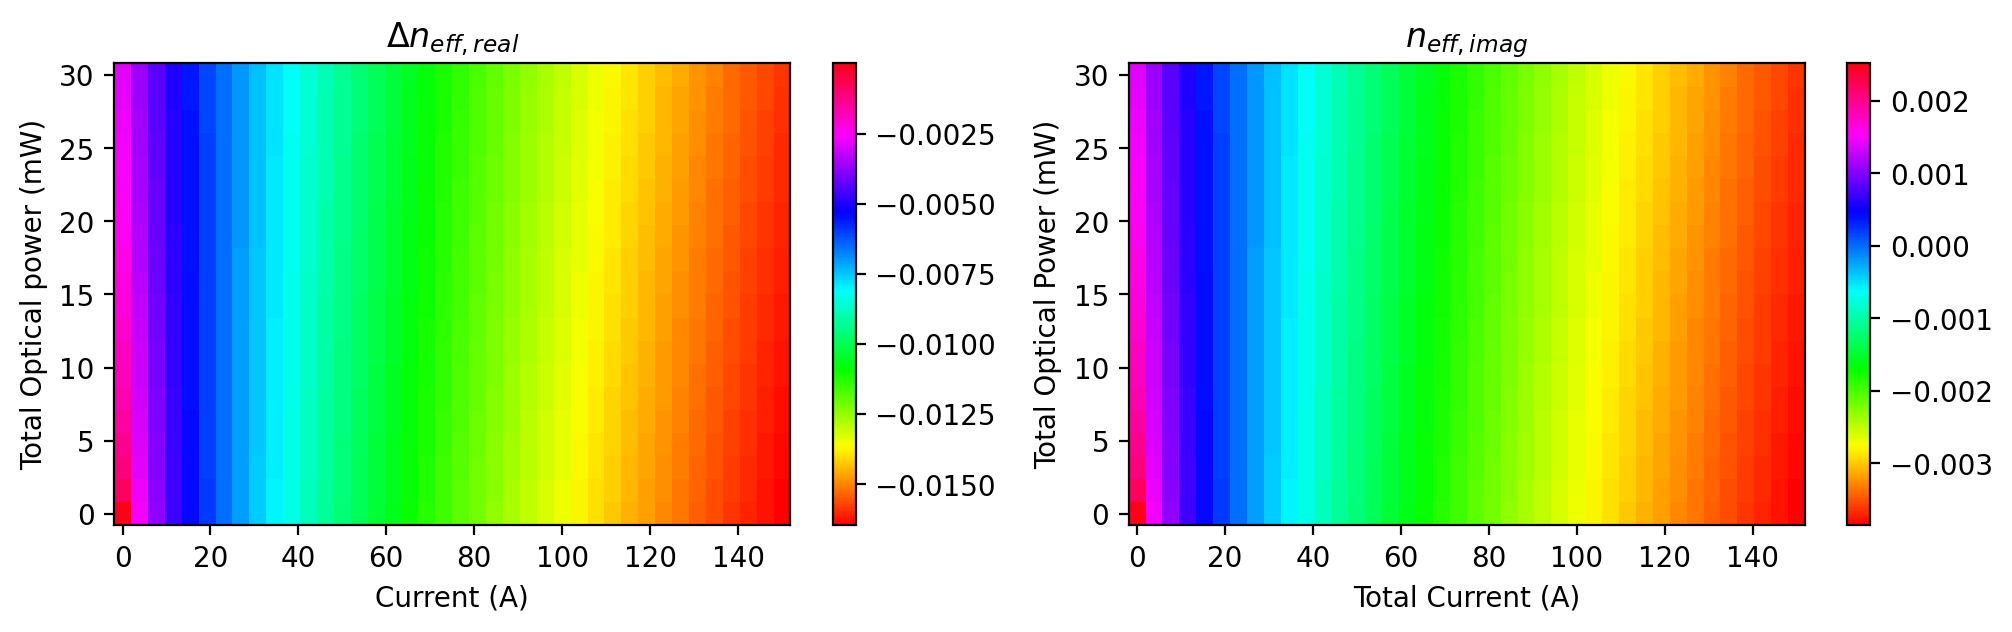

In [14]:
from tdwg.lib.simulation import *

thickness = 1*u.um
m = Material(dx=wg.dx, dz=wg.dz, thickness=thickness)
print("material properties")
#print(m)

max_P = 10e6*u.mW/u.cm**2 * Lx * thickness
max_current = 5 * u.kA/u.cm**2 * Lx * Lz
current_values = np.linspace(0,1,40) * max_current
P_values = np.linspace(0,1,20) * max_P

X, Y = np.meshgrid(current_values/(Nx*Nz),P_values/Nx)
n = m.update(X,Y)
fig, axs = plt.subplots(1, 2, figsize = [12,3], dpi = 200)

plt.sca(axs[0])
plt.pcolormesh(current_values.to(u.A).value, P_values.to(u.mW).value, np.real(n), cmap="hsv", shading="auto")
plt.colorbar()
plt.ylabel("Total Optical power (mW)")
plt.xlabel("Current (A)")
plt.title(r"$\Delta n_{eff,real}$")

plt.sca(axs[1])
plt.pcolormesh(current_values.to(u.A).value, P_values.to(u.mW).value, np.imag(n), cmap="hsv", shading="auto")
plt.colorbar()
plt.ylabel("Total Optical Power (mW)")
plt.xlabel("Total Current (A)")
plt.title(r"$n_{eff,imag}$")


The plots above are the steady-state effective index change at z=0 when a uniform current density is injected across Lx * Lz and a plane wave is incident on the z=0 (entrance) of the waveguide. The label Total Current is the total current across Lx * Lz, and the label Total Optical power is the total power across Lx * thickness.

(Lx, Ly, thickness: width, length, and thickness of 2D waveguide)

The $\Delta n_{eff, real}$ and $n_{eff,imag}$ plots look exactly the same (but with with different colorbar values) because they are both modeled as linear functions of the carrier density.

($n_{eff,imag}$ is defined such that there is optical gain when it's negative)

## Definition of input field $a$

I want to define the input field $a(x,z)$ such that the optical power across each $dx$ is

$dP = |a(x,z)|^2 dx$. 

In the mean time, we need $a$ to have the correct phase for the simulation.
Therefore, I define:

$a(x,z)= \frac{E}{|E|} \sqrt{\frac{1}{2} \epsilon_0 c \int_{-\infty}^{\infty} n_{eff,real}(x,z) |E(x,y,z)|^2 dy}$.

Since $max(\Delta n_{eff,real})$ is around 0.02, which is not too big, we might want to use a simpler definition:

$a(x,z)= \frac{E}{|E|} \sqrt{\frac{1}{2} \epsilon_0  n_{eff,0} c \int_{-\infty}^{\infty} |E(x,y,z)|^2 dy}$,

where $n_{eff,0}$ is the effective index without injected current or incident light.


## Testing Simulation with gain

The simulation takes an instance of the "Material" class as a parameter. I added the Material class in simulation.py to define material properties and use them to calculate n as a function of injected current and optical power.

The default material properties are currently approximate values for InGaAsP. For more details, refer to the comments in simulation.py.

The modified simulation sometimes run into errors, and the results kind of don't makes sense when the injected current causes any optical gain. So work still need to be done to solve these problems.

In [15]:
import warnings
#warnings.filterwarnings("error")
warnings.filterwarnings("ignore", category=DeprecationWarning)

static_n_amplitude = 1 # minimum n_imag of modulation pattern
xwidth = u.um * 50 # half-width-at-zero of delta_n pattern
DMD_xcenter = Lx/2 * resY/Lz-1.2
DMD_xwidth = xwidth * resY/Lz
DMD_zposition = zposition * resY/Lz
DMD_zwidth = zwidth * resY/Lz
z_range = np.arange(0, resY)
img = generate_grin_y_splitter(z_range, DMD_xcenter, DMD_xwidth/2)
img = 255 - 255 * (255-img.astype(float))**2/255**2
img = img.astype(np.uint8)
resY_eff = Lx*resY/Lz
source = img[0:int(resY_eff),:].astype(np.float32)
target_shape = (int(Nx*resY_eff/int(resY_eff)), Nz)
zoom_factors = (target_shape[0] / source.shape[0], target_shape[1] / source.shape[1])
target = zoom(source, zoom_factors, order=0)
target = target[0:Nx,:]
delta_n = torch.from_numpy(target.T/255*static_n_amplitude)
delta_n = delta_n.to(dtype=torch.complex64)  
delta_n_diffused = wg.smoothen_spatial_map(delta_n)

0.09113879835053988 -0.018889840323336297
0.037731550752464704 -0.004787931609896878



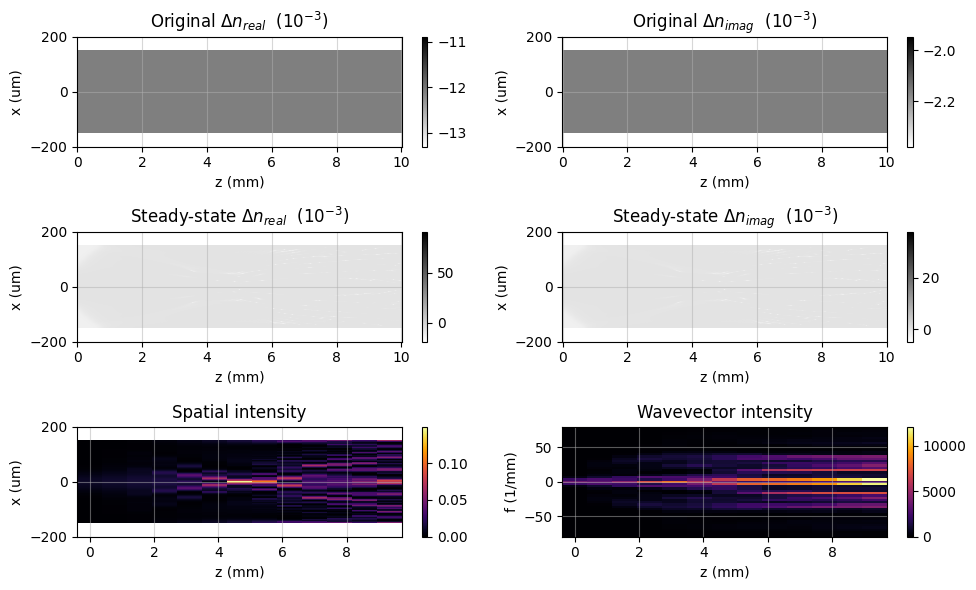

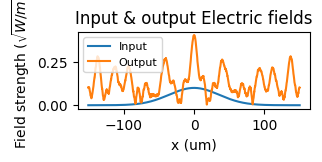

In [31]:
mod = reload(sys.modules['tdwg.lib.simulation']) # use imp.reload for Python 3  
vars().update(mod.__dict__)     # update the global namespace

electrode_length = 10e3
scale_factor = 1
carrier_diffusion_length = 5
# chip parameters (lengths in MICROMETERS)
input_length = 0e3 # distance between input facet and electrode (um)
output_length = 0e3 # distance between output facet and electrode (um)
n_wg = 2.2 # effective index of waveguide
delta_n_val= 1.e-3 # (effective) index modulation in bright regions
pixel_size = electrode_length / (scale_factor*resY)
# simulation parameters
Lz = (input_length+electrode_length+output_length)*u.um # length of waveguide in microns
Lx = 300*u.um # width of simulated waveguide area in microns 
Nx = 2**11 
dz = 1.55*u.um / delta_n_val / 100
Nz = int(Lz / dz)
current = (80+2e-6)*u.A/(Nx*Nz) * np.ones((Nz, Nx))
#current = (50+2e-6)*u.A/(Nx*Nz) * delta_n_diffused.numpy()

# create waveguide simulation object
wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50,current = current)
material = Material(wg.dx, wg.dz, dnrdN = -1e-20 * u.cm**3)
wg.material = material
wg.set_delta_n(0*delta_n_diffused)

w0 = 50 # beam waist (um)
rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
z0 = 0*u.mm
input_amplitude = np.sqrt(30*u.mW / Lx) # This is high, maybe close to the max allowable light amplitude
input_beam = (0.01+2e-8) * input_amplitude.si.value * torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0, center_um=0*u.um))

data_V_on = wg.run_simulation_slow(input_beam).clone()
#data_V_on = wg.run_simulation(input_beam).clone()


delta_n_active = wg.delta_n_active.numpy()
print(np.max(np.real(delta_n_active)),np.min(np.real(delta_n_active)))

print(np.max(np.imag(delta_n_active)),np.min(np.imag(delta_n_active)))

wg.plot_mats(renorm_flag=False)
print("")

fig, ax = plt.subplots(1, 1, figsize = [3,1])

plt.sca(ax)

plt.plot(wg.x_axis.to_value(),np.abs(input_beam.numpy()),label = "Input")
plt.plot(wg.x_axis.to_value(),np.abs(data_V_on.numpy()),label = "Output")
plt.xlabel("x (um)")
plt.ylabel(r"Field strength ($\sqrt{W/m}$)")
plt.title("Input & output Electric fields")
plt.legend(fontsize=8)


## Simple performance test

In [17]:
import time

#f_numeric = sp.lambdify((m.current, m.P), m.steady_state_N_function, 'numpy')

# Start timer
print(Nx, Nz)
iterations = Nx * Nz
scaling_factor = Nz
iterations = np.round(Nx * Nz / scaling_factor).astype(int)
print(iterations)
current_values = np.random.random(iterations)
P_values = np.random.random(iterations)

t0 = time.time()

#for j in range(iterations):
    #m.get_steady_state_N(1,2)
#    pass

t1 = time.time()

#for j in range(iterations):
#    f_numeric(current_values[j],P_values[j])

t2 = time.time()

for j in range(Nz):
    a = current_values*j
    a = a*j+a

t4 = time.time()

t3 = time.time()
for j in range(Nz):
    a = m.get_steady_state_N(current_values, P_values)

t4 = time.time()

time_cost = np.array([t1-t0, t2-t1, t3-t2, t4-t3])*scaling_factor**0
print(time_cost)


2048 645
2048
[0.         0.         0.01000524 1.23745537]


## Trash

In [22]:
current = torch.from_numpy(np.zeros((10,20), dtype=np.float32))
current.shape != (10, 20)

False

In [23]:
def compute_with_warning():
    mod = reload(sys.modules['tdwg.lib.simulation']) # use imp.reload for Python 3  
    vars().update(mod.__dict__)     # update the global namespace
    
    electrode_length = 10e3
    scale_factor = 1
    carrier_diffusion_length = 5
    # chip parameters (lengths in MICROMETERS)
    input_length = 0e3 # distance between input facet and electrode (um)
    output_length = 0e3 # distance between output facet and electrode (um)
    n_wg = 2.2 # effective index of waveguide
    delta_n_val= 1.e-3 # (effective) index modulation in bright regions
    pixel_size = electrode_length / (scale_factor*resY)
    # simulation parameters
    Lz = (input_length+electrode_length+output_length)*u.um # length of waveguide in microns
    Lx = 300*u.um # width of simulated waveguide area in microns 
    Nx = 2**11 
    dz = 1.55*u.um / delta_n_val / 100
    Nz = int(Lz / dz)
    current = (0.2+1e-9)*40*u.A/(Nx*Nz) * np.ones((Nz, Nx))
    # create waveguide simulation object
    wg = WaveguideSimulation(neff=n_wg, Lx=Lx, Lz=Lz, Nx=Nx, Nz=Nz, diffusion_length=carrier_diffusion_length*u.um,Ncom=50,current = current)
    
    m = wg.material
    delta_n = wg.get_delta_n_active_slice([1.000,1], [2,2])
    #print(m.dNdt, m.N)
    #print(sp.solve(m.dNdt, m.N))
    #print(m)
    
    
    w0 = 50 # beam waist (um)
    rayleigh_range = np.pi * w0**2 * n_wg / 1.55 * u.um
    z0 = 0*u.mm
    input_amplitude = np.sqrt(30*u.mW / Lx) # This is high, maybe close to the max allowable light amplitude
    print("input amplitude:",input_amplitude.si.value)
    input_beam = (0.1+1e-8) * input_amplitude.si.value * torch.from_numpy(gaussian_beam_from_q_parameter(wg, z0+1j*rayleigh_range, 0, center_um=0*u.um))
    
    data_V_on = wg.run_simulation_slow(input_beam).clone()
    wg.plot_mats(renorm_flag=False)
    print("")
    


In [27]:
a = torch.from_numpy(np.array([1,2])) * (1*u.um)